In [31]:
# -*- coding: utf-8 -*-
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from pymongo import MongoClient



In [5]:
import yaml
def yaml_loader(config_path):
    with open(config_path) as f:
        return yaml.load(f)
    
config=yaml_loader("../server/config.yaml")

In [59]:
db = MongoClient(config.get("mongo_uri").format(config.get("mongo_username"),config.get("mongo_password")))
coll = db.ethereum.orders
# GET max and min prices.
result=coll.aggregate([{"$group" : { "_id":None, "maxPrice" : {"$max": "$price"}, "minPrice" : {"$min": "$price"}
}}])
data=result.next()
print(data)
max_price = int(data["maxPrice"])
min_price = int(data["minPrice"])

# print(y)

result=coll.find({})
datas=[]
for data in result:
    datas.append(data)

{'_id': None, 'maxPrice': 223.99, 'minPrice': 201}


ETH Whales orders:


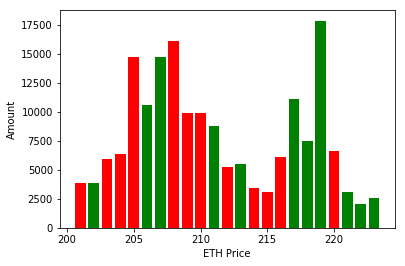

In [63]:
x = np.linspace(min_price,max_price,(max_price-min_price+1))
# print(x)

y = np.zeros((max_price-min_price+1))
y2 = np.zeros((max_price-min_price+1))


for data in datas:
        y[int(data["price"])-min_price]+=abs(data["amount"])
        y2[int(data["price"])-min_price]+=data["amount"]
# print(y)
# print(y2)
# print(x.shape)
for i in range(0,x.shape[0]):
    if y2[i]<0:
        y2[i]=y[i]
        y[i] = 0
    else:
        y2[i]=0
# print(y)
# print(y2)
print("ETH Whales orders:")
plt.xlabel('ETH Price')
plt.ylabel('Amount')

plt.bar(x, y, color="green")
plt.bar(x,y2,color="red")
plt.show()




ETH Whales orders larger than 300:


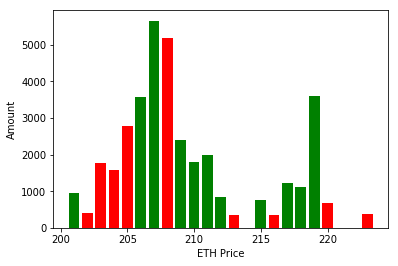

In [62]:
# Set a threshold for small orders.

y = np.zeros((max_price-min_price+1))
y2 = np.zeros((max_price-min_price+1))
threshold=300

for data in datas:
    if abs(data["amount"])>=threshold:
        y[int(data["price"])-min_price]+=abs(data["amount"])
        y2[int(data["price"])-min_price]+=data["amount"]

for i in range(0,x.shape[0]):
    if y2[i]<0:
        y2[i]=y[i]
        y[i] = 0
    else:
        y2[i]=0
# print(y)
# print(y2)
print("ETH Whales orders larger than 300:")


plt.xlabel('ETH Price')
plt.ylabel('Amount')

plt.bar(x, y, color="green")
plt.bar(x,y2,color="red")
plt.show()


